In [95]:
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv

In [96]:
import tensorflow as tf
print ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [97]:
adata = scv.datasets.gastrulation_erythroid()

In [98]:
dataset = './data/Gastrulation/erythroid_lineage.h5ad'
label = 'celltype'
exp_metrics = {}
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"),
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")]

In [99]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.AGENES_R2 = 1

------> Manully Specified Parameters <------
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 2000 highly variable genes.
Computing moments for 2000 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 513 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 505 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 503 (Criterion: genes have reads in more than 5% of total cells)
Using GPU card: 0


Loss (Total): 7298.199, (Spliced): 2042.108, (Unspliced): 5256.091: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [18:58<00:00,  8.12it/s]

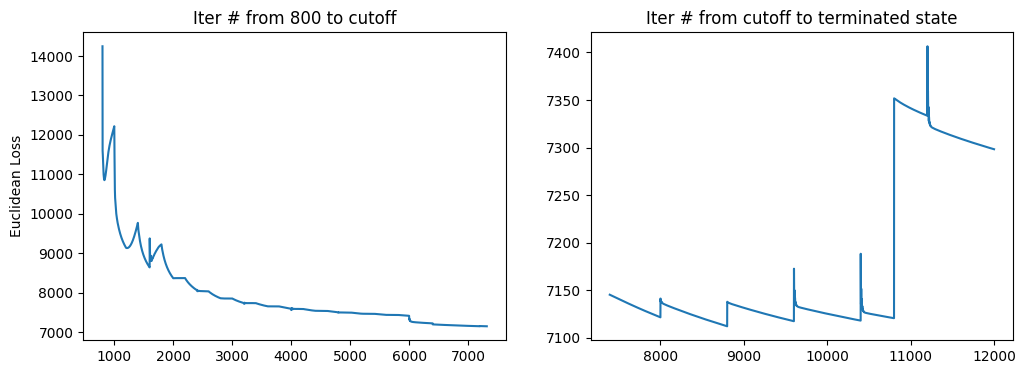

Loss (Total): 7298.199, (Spliced): 2042.108, (Unspliced): 5256.091: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [19:54<00:00, 10.05it/s]

Total loss 7111.911, vgene loss 7298.199


  0%|          | 0/9815 [00:00<?, ?cells/s]

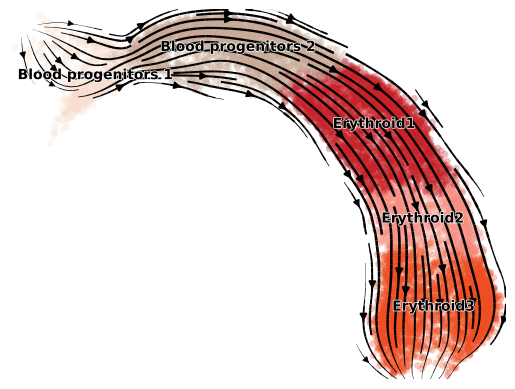

In [100]:
adata = utv.run_model('./data/Gastrulation/erythroid_lineage.h5ad', label, config_file=velo_config)
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')

In [105]:
import numpy as np
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
adata.obsp['T_fwd']=scv.utils.get_transition_matrix(adata).astype(np.float64)
adata.obsp['T_fwd']/=adata.obsp["T_fwd"].sum(-1)
adata.obsp['T_fwd'] = sp.sparse.csr_matrix(adata.obsp["T_fwd"])

In [106]:
import pandas as pd
df = pd.read_csv("Mus_musculus_TF", sep = "\t")
adata.var.istf = np.isin(adata.var.index.str.lower(), df.Symbol.str.lower())

In [178]:
import scanpy as sc
sc.tl.leiden(adata, resolution = 50)

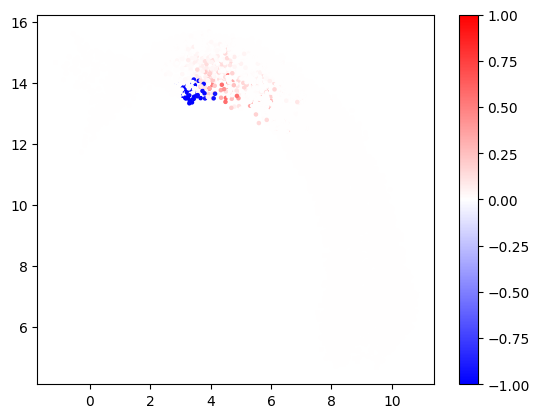

In [238]:
P = adata.obsp['T_fwd']
p0 = np.array(adata.obs.leiden.astype(int) == 1)
p1 = p0 @ P
p = p1 - p0
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], c = p, s = 5, cmap = "bwr", vmin = -1, vmax = 1)
plt.colorbar()

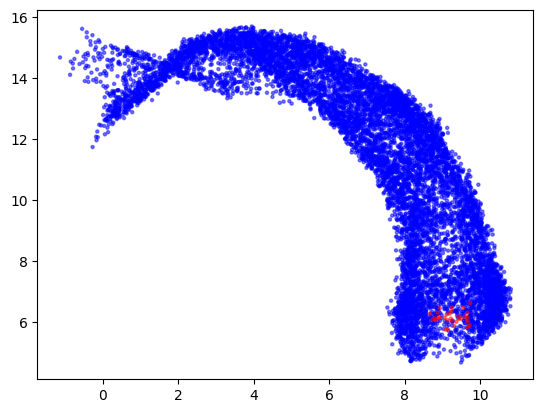

In [242]:
c = np.array([int(x) == 25 for x in adata.obs.leiden])
plt.scatter(adata.obsm["X_umap"][np.argsort(c), 0], adata.obsm["X_umap"][np.argsort(c), 1], c = np.sort(c), s = 5, cmap = "bwr", alpha = 0.5)

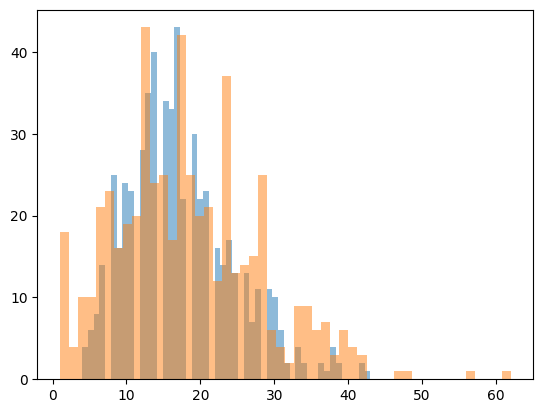

In [196]:
plt.hist(np.unique(adata.obs.leiden, return_counts = True)[1], alpha = 0.5, bins = 50)
plt.hist(np.unique(adata.obs.louvain, return_counts = True)[1], alpha = 0.5, bins = 50);

In [197]:
adata.var['istf'] = adata.var.istf

In [198]:
adata.write_h5ad("anndata.h5ad")

np.save("X.npy", adata.X[:, adata.var.istf].todense())
np.save("P.npy", adata.obsp["T_fwd"].todense())
np.save("X_pca.npy", adata.obsm["X_pca"])
np.save("X_umap.npy", adata.obsm["X_umap"])
np.save("louvain.npy", np.array(adata.obs.louvain.astype(int)))
np.save("leiden.npy", np.array(adata.obs.leiden.astype(int)))
np.save("dpt.npy", adata.obs.velocity_pseudotime)

In [202]:
adata.obsp["T_fwd"]

<9815x9815 sparse matrix of type '<class 'numpy.float64'>'
	with 2821728 stored elements in Compressed Sparse Row format>

2